# 1. Load Data
------

In [36]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [37]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

Using Colab cache for faster access to the 'vitoria-da-conquista-weather-data-september' dataset.
/kaggle/input/vitoria-da-conquista-weather-data-september
['temp.csv']


In [38]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [39]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Weather Conditions KMeans Clustering

--------------------


K-Means is an unsupervised machine learning algorithm used to group similar data into clusters. Clustering is the process of dividing a dataset into groups where elements within each group are more similar to each other than to elements in other groups. K-Means works by identifying K central points (centroids) and assigning each observation to the nearest centroid, iteratively adjusting the centroid positions until converging to a stable solution. In the climate context, this allows us to identify natural patterns in the data, such as "hot and humid days" or "cold and dry days," without manually defining these categories. This technique is especially useful for discovering hidden structures in large volumes of meteorological data.

| Cluster | Category Name | Characteristics |
|---------|---------------|-----------------|
| 0 | Cold and Dry | Low temperature and low humidity |
| 1 | Hot and Humid | High temperature and high humidity |
| 2 | Moderate | Moderate temperature and humidity |
| 3 | Cold and Humid | Low temperature and high humidity |

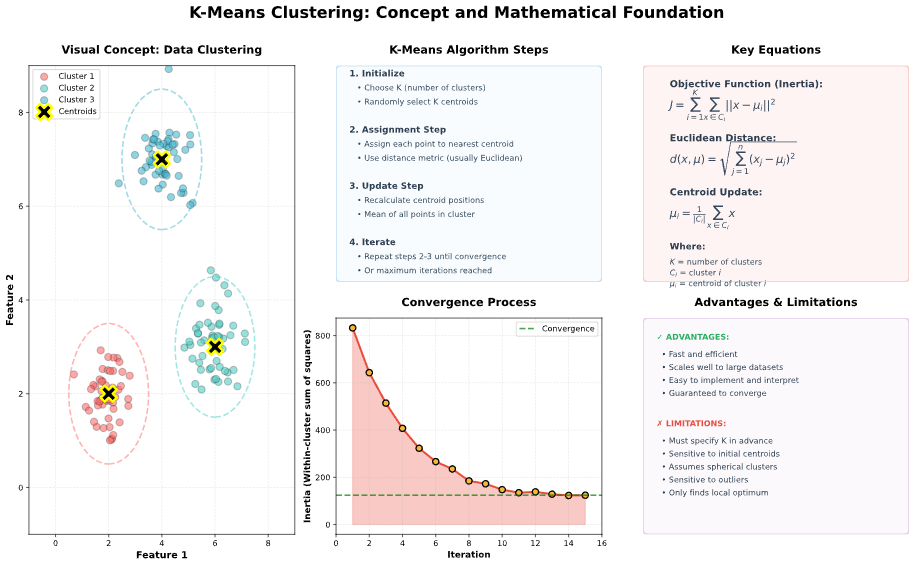

In [40]:
#Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [41]:
temp_columns = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
                'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C'] #all temperature sensors
humidity_columns = ['Umid_AHT20_pct', 'Umid_DHT11_pct'] # all humidity sensors
pressure_columns = ['Press_BMP280_hPa', 'Press_BMP180_hPa'] #all pressure sensors
#takes the average of all sensors to ensure that the measurement of all is relevant
df['Temp_Mean_C'] = df[temp_columns].mean(axis=1, skipna=True)
df['Humidity_Mean_pct'] = df[humidity_columns].mean(axis=1, skipna=True)
df['Pressure_Mean_hPa'] = df[pressure_columns].mean(axis=1, skipna=True)

In [42]:
features_cols = ['Temp_Mean_C', 'Humidity_Mean_pct', 'Pressure_Mean_hPa'] #feature columns that will be taken into consideration
#each feature is the average of a measurement variable
df_features = df[features_cols].dropna() #removes faulty data
print(f" Valid samples: {len(df_features):}")

 Valid samples: 82430


In [43]:
#normalizes the data for the model
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features) #normalization
#print to show data after normalization
print(f"\nMean after normalization: {features_scaled.mean(axis=0).round(4)}")
print(f"Standard deviation after normalization: {features_scaled.std(axis=0).round(4)}")


Mean after normalization: [-0. -0. -0.]
Standard deviation after normalization: [1. 1. 1.]


In [44]:
inertias = []
silhouette_scores = []

for k in range(2, 11) : #tests for number of clusters from 2 to 11
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10) #model
    kmeans_temp.fit(features_scaled) #applies to normalized data
    inertias.append(kmeans_temp.inertia_) #adds to vector for elbow method from training results
    silhouette_scores.append(silhouette_score(features_scaled, kmeans_temp.labels_))#adds to silhouette from training data

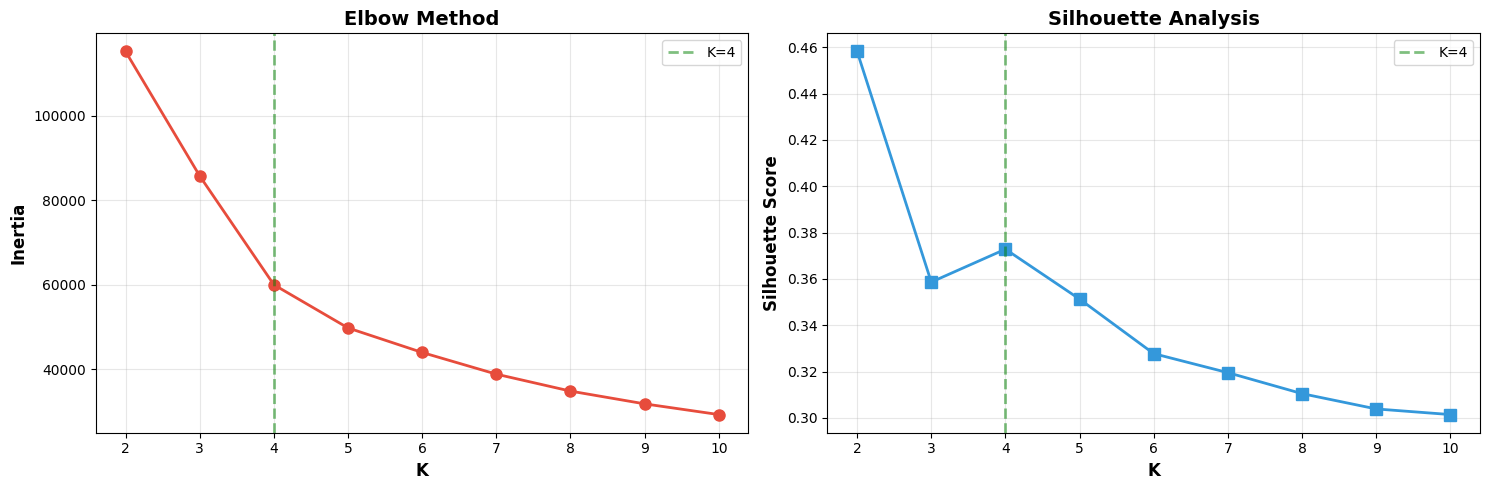

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) #size of subplots

# Plots the results of the elbow method from the analysis above
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='#E74C3C')
axes[0].set_xlabel('K', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=4, color='green', linestyle='--', linewidth=2, alpha=0.5, label='K=4')
axes[0].legend()

#Plots the silhouette index for each K cluster value
axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='#3498DB')
axes[1].set_xlabel('K', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=4, color='green', linestyle='--', linewidth=2, alpha=0.5, label='K=4')
axes[1].legend()

plt.tight_layout()
plt.show()

- The Elbow Method indicates K=4 as the optimal point, where inertia reduction significantly decreases from ~10,000 to ~6,000. The Silhouette Score of 0.37 for K=4 represents moderate quality, while 3D visualization confirms clear cluster separation with minimal overlap. K=4 was selected as the final solution, offering the best balance between climate granularity and interpretability for subsequent analyses.

In [46]:
n_clusters = 4 #number of clusters to be plotted
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300) #applies Kmeans considering:
#number of groups that the algorithm will separate
#value that ensures model reproducibility (42)
#number of times the algorithm runs with different initializations (10) -> chooses the best
#Stops the model after 300 iterations, even if the model does not converge
clusters = kmeans.fit_predict(features_scaled) #Model training to predict values based on normalized data.

df.loc[df_features.index, 'cluster'] = clusters #saves the clusters saved by the model
cluster_counts = df['cluster'].value_counts().sort_index() #orders the clusters from largest to smallest in number of points
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df_features)) * 100 #shows how many % the cluster represents of the total.
    print(f"  Cluster {cluster_id}: {count:,} samples ({percentage:.1f}%)")

  Cluster 0.0: 15,377 samples (18.7%)
  Cluster 1.0: 18,673 samples (22.7%)
  Cluster 2.0: 21,735 samples (26.4%)
  Cluster 3.0: 26,645 samples (32.3%)


In [47]:
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)#transforms into temperature the data that was normalized for training
centroids_df = pd.DataFrame(centroids_original, columns=features_cols) #creates dataframe with centroid points
centroids_df.index.name = 'Cluster'
print("\n Cluster characteristics:") #shows the average temperature, average humidity and average pressure of each cluster
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(f"  • Average temperature: {centroids_original[i, 0]:.2f}°C")
    print(f"  • Average humidity: {centroids_original[i, 1]:.2f}%")
    print(f"  • Average pressure: {centroids_original[i, 2]:.2f} hPa")


 Cluster characteristics:

Cluster 0:
  • Average temperature: 26.18°C
  • Average humidity: 42.38%
  • Average pressure: 916.60 hPa

Cluster 1:
  • Average temperature: 19.49°C
  • Average humidity: 71.13%
  • Average pressure: 917.80 hPa

Cluster 2:
  • Average temperature: 22.94°C
  • Average humidity: 53.04%
  • Average pressure: 919.70 hPa

Cluster 3:
  • Average temperature: 18.01°C
  • Average humidity: 72.39%
  • Average pressure: 920.94 hPa


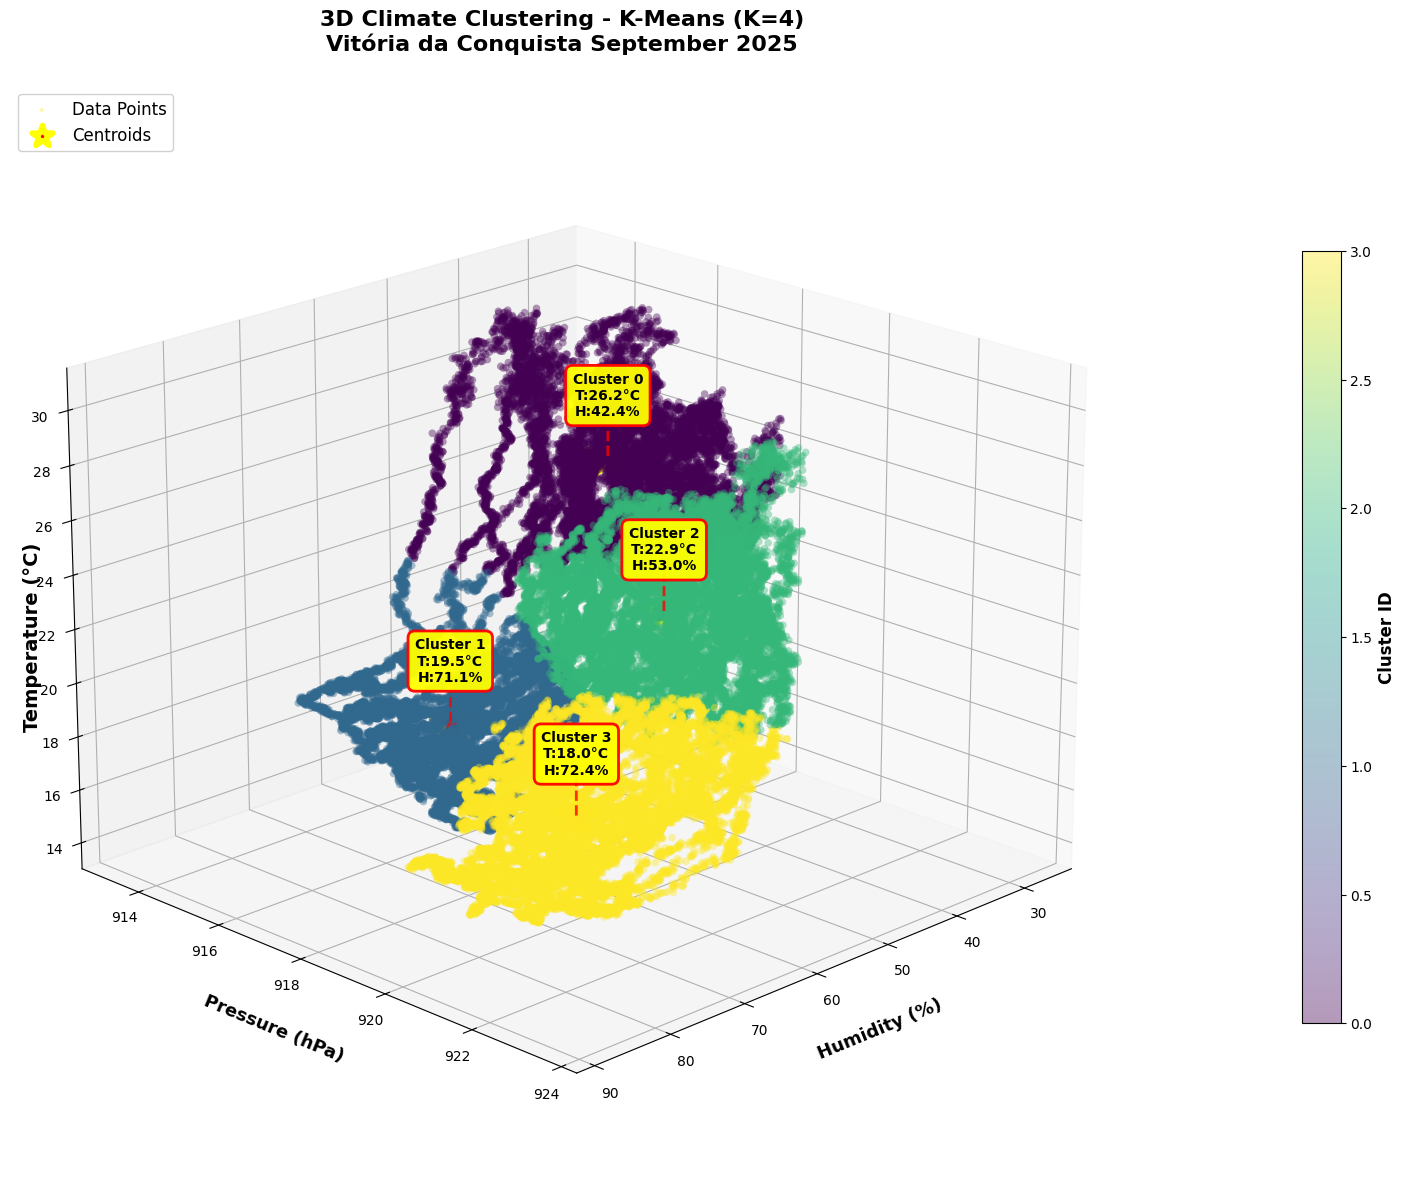

In [48]:
from mpl_toolkits.mplot3d import Axes3D #library for 3-dimensional plot

fig = plt.figure(figsize=(16, 12))#graph size
ax = fig.add_subplot(111, projection='3d')
#Plot cluster points
scatter = ax.scatter(df_features['Humidity_Mean_pct'], #humidity points
                    df_features['Pressure_Mean_hPa'], #pressure points
                    df_features['Temp_Mean_C'], #temperature points
                    c=clusters,
                    cmap='viridis',
                    s=30,
                    alpha=0.4,
                    edgecolors='none',
                    label='Data Points',
                    depthshade=False)

#Plot centroids
centroids_scatter = ax.scatter(centroids_original[:, 1],
                              centroids_original[:, 2],
                              centroids_original[:, 0],
                              c='red',
                              s=1000,
                              marker='*',
                              edgecolors='yellow',
                              linewidth=4,
                              label='Centroids',
                              zorder=1000,
                              depthshade=False)
#labels on centroids
for i in range(n_clusters):
    x_pos = centroids_original[i, 1]
    y_pos = centroids_original[i, 2]
    z_pos = centroids_original[i, 0]
    ax.text(x_pos, y_pos, z_pos + 1.5,
           f'Cluster {i}\nT:{z_pos:.1f}°C\nH:{x_pos:.1f}%',
           fontsize=10,
           fontweight='bold',
           color='black',
           ha='center',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow',
                    edgecolor='red', linewidth=2, alpha=0.95),
           zorder=1001)
    ax.plot([x_pos, x_pos], [y_pos, y_pos], [z_pos, z_pos + 1.5],
           color='red', linewidth=2, linestyle='--', alpha=0.8, zorder=999)
ax.set_xlabel('Humidity (%)', fontsize=13, fontweight='bold', labelpad=15) #x-axis label
ax.set_ylabel('Pressure (hPa)', fontsize=13, fontweight='bold', labelpad=15) #y-axis label

# Get Z-axis limits
z_min, z_max = ax.get_zlim()
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
#place z label (did not fit in the model above)
ax.text2D(0.02, 0.5, 'Temperature (°C)',
         transform=ax.transAxes,
         fontsize=14,
         fontweight='bold',
         rotation=90,
         va='center',
         ha='center')

# Title
ax.set_title('3D Climate Clustering - K-Means (K=4)\nVitória da Conquista September 2025',
            fontsize=16, fontweight='bold', pad=25)
ax.view_init(elev=20, azim=45) #graph angle
ax.legend(fontsize=12, loc='upper left', framealpha=0.9, markerscale=0.5)
cbar = plt.colorbar(scatter, ax=ax, pad=0.12, shrink=0.7) #place for clusters
cbar.set_label('Cluster ID', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [49]:
#evaluation metrics
silhouette_avg = silhouette_score(features_scaled, clusters)
davies_bouldin = davies_bouldin_score(features_scaled, clusters)

print(f"\n Silhouette Score: {silhouette_avg:.4f}")
print(f"\n Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"\n Inertia: {kmeans.inertia_:.2f}")
print(f"\n Number of iterations: {kmeans.n_iter_}")


 Silhouette Score: 0.3728

 Davies-Bouldin Index: 0.8881

 Inertia: 59996.52

 Number of iterations: 12


In [50]:
output_cols = ['Timestamp', 'Temp_Mean_C', 'Humidity_Mean_pct',
               'Pressure_Mean_hPa', 'cluster'] #columns that will appear in the csv
df_output = df[output_cols].copy() #output with the values and also the cluster that the model determined.
df_output.to_csv('climate_clusters.csv', index=False)
centroids_df.to_csv('cluster_centroids.csv')

The K-Means algorithm successfully identified four distinct climate patterns in Vitória da Conquista's September 2025 data, achieving a Silhouette Score of 0.37 (moderate quality) and converging in few iterations. The 3D visualization reveals clear spatial separation between clusters, with minimal overlap when considering all three meteorological features simultaneously. Cluster 0 represents the warmest conditions (26.2°C, 42.4% humidity), while Cluster 3 shows the coolest temperatures (18.0°C) with high humidity (72.4%), indicating different atmospheric regimes. The pressure variation across clusters (914-924 hPa) suggests the algorithm captured both thermal and baric differences in the local climate. This unsupervised classification provides an objective framework for understanding weather pattern diversity without predetermined categories.

| Cluster ID | Temperature | Humidity | Pressure | Climate Pattern Description |
|------------|-------------|----------|----------|---------------------------|
| **0** | 26.2°C | 42.4% | ~920 hPa | **Hot and Dry** - Warm conditions with low moisture, typical afternoon weather |
| **1** | 19.5°C | 71.1% | ~918 hPa | **Cool and Humid** - Lower temperatures with high moisture, early morning/evening conditions |
| **2** | 22.9°C | 53.0% | ~917 hPa | **Moderate** - Balanced temperature and humidity, transitional periods |
| **3** | 18.0°C | 72.4% | ~916 hPa | **Cold and Very Humid** - Coolest conditions with highest moisture, night/pre-dawn patterns |